## Finetuning Faster RCNN

### 1. Find best parameters (with automated parameter search)
### 2. Final training (moved to Colab notebook)
### 3. Test if more data is needed

In [20]:
import copy
import gc
import os

import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.trial import TrialState
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms, models
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [21]:
labels_csv = './labels_two_classes_various_sizes.csv'

### Comparing different models for prediction latency

In [29]:
model_res50 = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
for param in model_res50.parameters():
    param.requires_grad = False
model_res50.eval()

model_res50_2 = models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
for param in model_res50_2.parameters():
    param.requires_grad = False
model_res50_2.eval()

model_320 = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
for param in model_320.parameters():
    param.requires_grad = False
model_320.eval()

model_full = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
for param in model_full.parameters():
    param.requires_grad = False
model_full.eval()



/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weigh

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [8]:
x = [torch.rand(3, 320, 480), torch.rand(3, 480, 640)]

In [ ]:
%time model_full(x)

In [10]:
%time model_full(x)

CPU times: user 914 ms, sys: 179 ms, total: 1.09 s
Wall time: 553 ms


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [12]:
%time model_320(x)

CPU times: user 207 ms, sys: 10.3 ms, total: 217 ms
Wall time: 109 ms


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [13]:
%time model_res50(x)

CPU times: user 7.97 s, sys: 1.1 s, total: 9.07 s
Wall time: 4.56 s


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [14]:
%time model_res50_2(x)

CPU times: user 17.1 s, sys: 1.72 s, total: 18.9 s
Wall time: 9.52 s


[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

In [ ]:
def get_model_simple():
    
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, box_detections_per_img=3)
    for param in model.parameters():
        param.requires_grad = False
    num_classes = 3  # painting, object + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    return model


In [14]:
model = get_model_simple()
model.transform
model.train()

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [23]:
RPNtransform = transforms.Compose([ #transforms.Resize((640,640)),
                                    transforms.ToTensor()
                                    ])


def get_strat_sample_idc(ds, train_frac, min_images_class, nr_classes=-1, seed=0):
    """
    Creates train/test split in the form of lists of indexes.
    
    :param ImageFolder ds: pytorch datasets imagefolder
    :param train_frac float: fraction of training set
    :param min_images_class int: minimum number of images per class, if a class has less, class will be skipped
    :param nr_class int: number of classes to be used, defaults to all classes (-1)
    """
    
    np.random.seed(seed)
    if nr_classes == -1:
        all_labels_unique = set(ds.targets)
    else:
        all_labels_unique = np.random.choice(a=list(set(ds.targets)), size=nr_classes, replace=False)
    
    train_idc = []
    val_idc = []
    all_labels = np.array(ds.targets)
    all_labels_idc = np.arange(0, all_labels.size)

    for label in all_labels_unique:

        label_idc = np.where(all_labels==label)[0]
        label_subset = all_labels_idc[label_idc]
        if label_subset.size < min_images_class:
            continue

        train_size = int(np.ceil(label_subset.size * train_frac))
        train = np.random.choice(a=label_subset, size=train_size, replace=False)
        train_idc += train.tolist()

        val_m = np.isin(label_subset, train, invert=True)
        val = label_subset[val_m]
        val_idc += val.tolist()
        
    return train_idc, val_idc


class RPNDataset(torch.utils.data.Dataset):
    def __init__(self, imageFolder, labelsPath, subset=None, transform=None):
        
        self.transform = transform
        
        self.df = pd.read_csv(labelsPath, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
        self.labels = self.df.target
        
        # convert the bounding box coordinates from starting point + box height/width to two points as fractions of height/width
        self.x1 = (self.df.c1/self.df.w).to_numpy()
        self.y1 = (self.df.c2/self.df.h).to_numpy()
        self.x2 = ((self.df.c1 + self.df.c3)/self.df.w).to_numpy()
        self.y2 = ((self.df.c2 + self.df.c4)/self.df.h).to_numpy()
        self.images = [os.path.join(imageFolder, image) for image in self.df.imageFile]
        
        if type(self.df.target[0])==str:
            self.targets = [0 for i in range(len(self.df))]
            for idx, target in enumerate(self.df.target):
                if target == 'image':
                    self.targets[idx] = 1
                elif target == 'object':
                    self.targets[idx] = 0
                else:
                    print( f'error in {target} {idx}')
            self.labels = self.targets
            
        if subset is not None:
            self.x1 = self.x1[subset]
            self.y1 = self.y1[subset]
            self.x2 = self.x2[subset]
            self.y2 = self.y2[subset]
            self.labels = [self.labels[idx] for idx in subset]
            self.images = [self.images[idx] for idx in subset]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img.thumbnail((640,640))
        w = img.width 
        h = img.height
        
        box = torch.tensor([self.x1[index]*w, self.y1[index]*h, self.x2[index]*w, self.y2[index]*h], dtype=torch.float32)
        target = {
                'boxes': box,
                'labels': torch.tensor(self.labels[index]),
                'image_id' : torch.tensor(index),
                'image_path': self.images[index]
            }
        
        if not img.mode == 'RGB':
            img = img.convert('RGB')
        img = RPNtransform(img)
        return img, target

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

data = RPNDataset('./Images', labels_csv)
batch_size = 6
train, val = get_strat_sample_idc(data, 0.6, 2)
train_data = RPNDataset('./Images', labels_csv, train)
val_data = RPNDataset('./Images', labels_csv, val)
image_datasets = {'train': train_data, 'val': val_data}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn) for x in ['train', 'val']}
data_loader_all = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [7]:
df = pd.read_csv(labels_csv, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
df

target   c1   c2   c3   c4  \
0      image   89  153  376  285   
1      image  105  155  390  287   
2      image   26   98  533  408   
3      image   21   16  559  429   
4      image   98  150  236  309   
...      ...  ...  ...  ...  ...   
1629  object   32   92  418  344   
1630   image   11   14  216  275   
1631   image   77  142  158  130   
1632   image  408  127  177  128   
1633   image  275   55  170  191   

                                              imageFile    w    h  
0                               IMG_20210625_150705.jpg  562  600  
1                               IMG_20210625_150712.jpg  566  600  
2                               IMG_20210625_150718.jpg  597  600  
3                      IMG_20210625_150718 (copy 1).jpg  600  470  
4                               IMG_20210625_151623.jpg  450  600  
...                                                 ...  ...  ...  
1629        the-national-palace-museum-1787828_1280.jpg  640  474  
1630  the-nymphs-of-parthenope-led-toward-the-banks-...  240  308  
1631  thomascole_02_wide-12cdf689fad319885471c468f32...  640  359  
1632  thomascole_02_wide-12cdf689fad319885471c468f32...  640  359  
1633                             women-7810845_1280.jpg  640  426  

[1634 rows x 8 columns]

## 1. Find best parameters (first wider range, then more narrow)

In [18]:
def tune_rpn_model(trial):
    
    strat = StratifiedKFold(3, shuffle=True)
    
    lr_bb = trial.suggest_loguniform('lr_bb', 0.002, 0.008)
    wd_bb = trial.suggest_loguniform('wd_bb', 1e-6, 1e-5)
    momentum = trial.suggest_uniform('momentum', 0.80, 0.94)
    
    num_epochs = 4
    
    batch_size = 6
    
    val_loss_history = []
    best_loss = 10e10

    model = get_model_simple()

    print('to update: ')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    
    model.train()
    optimizer = torch.optim.SGD(params_to_update, lr=lr_bb, weight_decay=wd_bb, momentum=momentum)
    
    folds = strat.split(data.targets, data.targets)

    
    for epoch in range(num_epochs):
        
        folds = strat.split(data.targets, data.targets)
        
        epoch_val_loss = 0
        epoch_train_loss = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = []
        val_loss = []

        for train_ds_idc, val_ds_idc in folds:

            train_data = RPNDataset('./Images', labels_csv, train_ds_idc)
            val_data = RPNDataset('./Images', labels_csv, val_ds_idc)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
            val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

            # Each epoch has a training and validation phase

            running_loss = 0.0

            running_corrects = 0
            
            
            # Training
            with torch.set_grad_enabled(True):

                for img, targets in train_loader:

                    img = list(image for image in img)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)

                    loss = sum(loss for loss in loss_dict.values())
                    loss_value = loss.item()

                    train_loss.append(loss_value) 

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # Validation
            with torch.set_grad_enabled(False):

                for img, targets in val_loader:

                    img = list(image for image in img)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)

                    loss = sum(loss for loss in loss_dict.values())
                    loss_value = loss.item()

                    val_loss.append(loss_value)
                    
        epoch_train_loss = sum(train_loss)/len(train_loss)

        print('Train avg batch Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/batch_size))
        
        epoch_val_loss = sum(val_loss)/len(val_loss)

        print('Val avg batch Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_val_loss, epoch_val_loss/batch_size))
              
        val_loss_history.append(epoch_val_loss)

        trial.report(epoch_val_loss, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            __builtins__.best_model_wts = copy.deepcopy(model.state_dict())
    
    
    trial_loss = sum(val_loss_history)/len(val_loss_history)
    
    print('val loss history: ', val_loss_history, trial_loss)
        
    return trial_loss

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(),direction="minimize",study_name='bb')
study.optimize(tune_rpn_model, n_trials=16, timeout=28000, gc_after_trial=False) 

[I 2023-07-15 04:06:10,315] A new study created in memory with name: bb
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2594, per Instance: 0.0432 
Val avg batch Loss: 0.2335,  per Instance: 0.0389 
Epoch 1/3
----------
Train avg batch Loss: 0.2215, per Instance: 0.0369 
Val avg batch Loss: 0.2186,  per Instance: 0.0364 
Epoch 2/3
----------
Train avg batch Loss: 0.2159, per Instance: 0.0360 
Val avg batch Loss: 0.2196,  per Instance: 0.0366 
Epoch 3/3
----------


[I 2023-07-15 05:37:43,392] Trial 0 finished with value: 0.22074914199637843 and parameters: {'lr_bb': 0.006514040811448659, 'wd_bb': 9.489605701253317e-06, 'momentum': 0.8815681223047173}. Best is trial 0 with value: 0.22074914199637843.


Train avg batch Loss: 0.2132, per Instance: 0.0355 
Val avg batch Loss: 0.2112,  per Instance: 0.0352 
val loss history:  [0.233542752571595, 0.2186044428920571, 0.2196023477575718, 0.21124702476428978] 0.22074914199637843


/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2691, per Instance: 0.0449 
Val avg batch Loss: 0.2405,  per Instance: 0.0401 
Epoch 1/3
----------
Train avg batch Loss: 0.2247, per Instance: 0.0374 
Val avg batch Loss: 0.2239,  per Instance: 0.0373 
Epoch 2/3
----------
Train avg batch Loss: 0.2176, per Instance: 0.0363 
Val avg batch Loss: 0.2167,  per Instance: 0.0361 
Epoch 3/3
----------


[I 2023-07-15 07:01:04,956] Trial 1 finished with value: 0.2231424653172602 and parameters: {'lr_bb': 0.0044307957930878675, 'wd_bb': 1.1705566870530096e-06, 'momentum': 0.8161086619071785}. Best is trial 0 with value: 0.22074914199637843.


Train avg batch Loss: 0.2120, per Instance: 0.0353 
Val avg batch Loss: 0.2114,  per Instance: 0.0352 
val loss history:  [0.24054065821590004, 0.2239010479478609, 0.21671899962119567, 0.21140915548408423] 0.2231424653172602


/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2774, per Instance: 0.0462 
Val avg batch Loss: 0.2508,  per Instance: 0.0418 
Epoch 1/3
----------
Train avg batch Loss: 0.2293, per Instance: 0.0382 
Val avg batch Loss: 0.2250,  per Instance: 0.0375 
Epoch 2/3
----------
Train avg batch Loss: 0.2196, per Instance: 0.0366 
Val avg batch Loss: 0.2202,  per Instance: 0.0367 
Epoch 3/3
----------


[I 2023-07-15 08:25:27,028] Trial 2 finished with value: 0.2276137650572446 and parameters: {'lr_bb': 0.0030259054145097084, 'wd_bb': 1.908674002809085e-06, 'momentum': 0.8221063908770374}. Best is trial 0 with value: 0.22074914199637843.


Train avg batch Loss: 0.2122, per Instance: 0.0354 
Val avg batch Loss: 0.2146,  per Instance: 0.0358 
val loss history:  [0.2507653508485455, 0.22495634302551493, 0.2201722957494058, 0.21456107060551208] 0.2276137650572446


/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2627, per Instance: 0.0438 
Val avg batch Loss: 0.2453,  per Instance: 0.0409 
Epoch 1/3
----------
Train avg batch Loss: 0.2272, per Instance: 0.0379 
Val avg batch Loss: 0.2236,  per Instance: 0.0373 
Epoch 2/3
----------
Train avg batch Loss: 0.2168, per Instance: 0.0361 
Val avg batch Loss: 0.2146,  per Instance: 0.0358 
Epoch 3/3
----------


[I 2023-07-15 09:49:03,593] Trial 3 finished with value: 0.22423130098471056 and parameters: {'lr_bb': 0.005354351653466267, 'wd_bb': 1.407113578345783e-06, 'momentum': 0.9292936683978342}. Best is trial 0 with value: 0.22074914199637843.


Train avg batch Loss: 0.2142, per Instance: 0.0357 
Val avg batch Loss: 0.2134,  per Instance: 0.0356 
val loss history:  [0.24532554481492375, 0.22364202526571986, 0.2145652039856701, 0.21339242987252854] 0.22423130098471056


/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2859, per Instance: 0.0477 
Val avg batch Loss: 0.2520,  per Instance: 0.0420 
Epoch 1/3
----------
Train avg batch Loss: 0.2328, per Instance: 0.0388 
Val avg batch Loss: 0.2309,  per Instance: 0.0385 
Epoch 2/3
----------
Train avg batch Loss: 0.2216, per Instance: 0.0369 
Val avg batch Loss: 0.2205,  per Instance: 0.0368 
Epoch 3/3
----------


[I 2023-07-15 11:12:48,835] Trial 4 finished with value: 0.2292546976439573 and parameters: {'lr_bb': 0.0020583503200170385, 'wd_bb': 1.392586818105093e-06, 'momentum': 0.8504257684882257}. Best is trial 0 with value: 0.22074914199637843.


Train avg batch Loss: 0.2192, per Instance: 0.0365 
Val avg batch Loss: 0.2136,  per Instance: 0.0356 
val loss history:  [0.2520091968414548, 0.23087218687647865, 0.22052946637619983, 0.21360794048169593] 0.2292546976439573


/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/3
----------
Train avg batch Loss: 0.2528, per Instance: 0.0421 
Val avg batch Loss: 0.2318,  per Instance: 0.0386 
Epoch 1/3
----------


[I 2023-07-15 11:55:08,298] Trial 5 pruned. 


Train avg batch Loss: 0.2252, per Instance: 0.0375 
Val avg batch Loss: 0.2282,  per Instance: 0.0380 


In [20]:
import pickle
pickle.dump(__builtins__.best_model_wts, open('mobilenet_320_intermediate_23.pkl', 'wb'))


In [33]:
model = get_model_simple()
model.load_state_dict(__builtins__.best_model_wts)

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [19]:
study.best_trial

FrozenTrial(number=0, values=[0.22074914199637843], datetime_start=datetime.datetime(2023, 7, 15, 4, 6, 10, 322203), datetime_complete=datetime.datetime(2023, 7, 15, 5, 37, 43, 391516), params={'lr_bb': 0.006514040811448659, 'wd_bb': 9.489605701253317e-06, 'momentum': 0.8815681223047173}, distributions={'lr_bb': LogUniformDistribution(high=0.008, low=0.002), 'wd_bb': LogUniformDistribution(high=1e-05, low=1e-06), 'momentum': UniformDistribution(high=0.94, low=0.8)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.233542752571595, 1: 0.2186044428920571, 2: 0.2196023477575718, 3: 0.21124702476428978}, trial_id=0, state=TrialState.COMPLETE, value=None)

## 2. Final training with fixed parameters (continued in Colab notebook)

In [9]:
best_and_stable = {'lr_bb': 0.006436278316823579, 'wd_bb': 1.1003497255547178e-06, 'momentum': 0.8390545210748475}

lr_bb = best_and_stable['lr_bb']
wd_bb = best_and_stable['wd_bb'] 
momentum = best_and_stable['momentum'] 
    
num_epochs = 28

train_loss_history = []
val_loss_history = []
best_loss = 10e10

model = get_model_simple()

print('to update: ')
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

model.train()
optimizer = torch.optim.SGD(params_to_update, lr=lr_bb, weight_decay=wd_bb, momentum=momentum)


strat = StratifiedKFold(3, shuffle=True)
folds = strat.split(data.targets, data.targets)

    
for epoch in range(num_epochs):

    folds = strat.split(data.targets, data.targets)

    epoch_val_loss = 0
    epoch_train_loss = 0
    
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    train_loss = []
    val_loss = []

    for train_ds_idc, val_ds_idc in folds:

        train_data = RPNDataset('./Images', labels_csv, train_ds_idc)
        val_data = RPNDataset('./Images', labels_csv, val_ds_idc)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)


        # Each epoch has a training and validation phase

        running_loss = 0.0

        running_corrects = 0
        
        
        # Training
        with torch.set_grad_enabled(True):

            for img, targets in train_loader:

                img = list(image for image in img)
                targets = [{k: v for k, v in t.items()} for t in targets]

                for target in targets:
                    target['boxes'] = target['boxes'].unsqueeze(0)
                    target['labels'] = target['labels'].unsqueeze(0)
                    target['image_id'] = target['image_id'].unsqueeze(0)

                loss_dict = model(img, targets)
                
                loss = sum(loss for loss in loss_dict.values())
                
                loss_value = loss.item()

                train_loss.append(loss_value) 

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        
        # Validation
        with torch.set_grad_enabled(False):

            for img, targets in val_loader:

                img = list(image for image in img)
                targets = [{k: v for k, v in t.items()} for t in targets]

                for target in targets:
                    target['boxes'] = target['boxes'].unsqueeze(0)
                    target['labels'] = target['labels'].unsqueeze(0)
                    target['image_id'] = target['image_id'].unsqueeze(0)

                loss_dict = model(img, targets)

                loss = sum(loss for loss in loss_dict.values())
                
                loss_value = loss.item()

                val_loss.append(loss_value)

    epoch_train_loss = sum(train_loss)/len(train_loss)

    print('Train avg batch Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/batch_size))

    train_loss_history.append(epoch_train_loss)
    
    epoch_val_loss = sum(val_loss)/len(val_loss)

    print('Val avg batch Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_val_loss, epoch_val_loss/batch_size))

    val_loss_history.append(epoch_val_loss)

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

print('Val Batch Loss History: ', val_loss_history)            
            
import pickle
pickle.dump(best_model_wts, open('mobilenet_320_all_13_07_23.pkl', 'wb'))

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


to update: 
	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/27
----------
Train avg batch Loss: 0.2708, per Instance: 0.0677 
Val Loss: 0.2661,  per Instance: 0.0005 
Val avg batch Loss: 0.2661,  per Instance: 0.0665 
Epoch 1/27
----------
Train avg batch Loss: 0.2361, per Instance: 0.0590 
Val Loss: 0.2409,  per Instance: 0.0004 
Val avg batch Loss: 0.2409,  per Instance: 0.0602 
Epoch 2/27
----------
Train avg batch Loss: 0.2254, per Instance: 0.0564 
Val Loss: 0.2306,  per Instance: 0.0004 
Val avg batch Loss: 0.2306,  per Instance: 0.0577 
Epoch 3/27
----------
Train avg batch Loss: 0.2278, per Instance: 0.0570 
Val Loss: 0.2254,  per Instance: 0.0004 
Val avg batch Loss: 0.2254,  per Instance: 0.0563 
Epoch 4/27
----------
Train avg batch Loss: 0.2217, per Instance: 0.0554 
Val Loss: 0.2250,  per Instance: 0.0004 
Val avg batch Loss: 0.2250,  per Instance

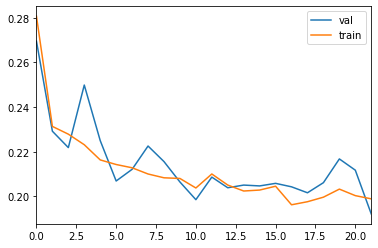

In [59]:
pd.DataFrame({'val':val_loss_history, 'train':train_loss_history}).plot() #700

In [50]:
import pickle
#pickle.dump(model.state_dict(), open('mobilenet_test_size.pkl', 'wb'))
model_dict = pickle.load(open('mobilenet_320_all_02_07_23.pkl', 'rb'))
best_model_wts = model_dict
model = get_model_simple()
model.load_state_dict(model_dict)
model.eval()

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [51]:
output = model(data[34][0].unsqueeze(0))
bboxes = output[0]['boxes']
bb = bboxes.detach().numpy()
bb

array([[ 49.78744,  74.38256, 344.35828, 492.10233]], dtype=float32)

[60.903221130371094, 37.84334945678711, 410.6290588378906, 554.2600708007812]
[13.655991554260254, 50.17979049682617, 321.2124938964844, 604.27392578125]
[13.607597351074219, 0.0, 480.0, 607.9935913085938]
[]
[159.80056762695312, 13.701698303222656, 394.11077880859375, 565.33935546875]


<ipython-input-52-91fcac4582aa>:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bbox:


[68.50360107421875, 18.640663146972656, 257.3467102050781, 294.1218566894531]
[138.86476135253906, 0.0, 498.07110595703125, 579.3629150390625]
[]
[0.0, 0.0, 425.0, 606.3164672851562]
[14.580524444580078, 28.124797821044922, 320.6141662597656, 600.639892578125]
[76.0823974609375, 94.53071594238281, 433.89190673828125, 557.1485595703125]
[137.0397491455078, 149.663818359375, 506.7273864746094, 530.338134765625]
[27.099849700927734, 38.80465316772461, 410.9466247558594, 546.467041015625]
[32.81712341308594, 42.23286819458008, 439.67694091796875, 532.9644775390625]
[44.82200241088867, 74.52458190917969, 516.9573974609375, 504.32843017578125]
[55.71403884887695, 110.2499008178711, 537.0113525390625, 548.2427978515625]
[349.6426086425781, 215.45494079589844, 438.8468322753906, 306.2822570800781]
[191.75218200683594, 70.09620666503906, 347.81805419921875, 434.24365234375]
[0.0, 10.018899917602539, 450.0, 498.19122314453125]
[96.66756439208984, 108.28936767578125, 415.3753967285156, 562.278930

[51.41944885253906, 61.424320220947266, 351.0651550292969, 452.08331298828125]
[67.66664123535156, 105.65475463867188, 379.18670654296875, 469.0634460449219]
[146.470458984375, 67.65168762207031, 483.57696533203125, 336.8104248046875]
[]
[108.29296875, 114.80409240722656, 342.3622131347656, 453.44500732421875]
[]
[34.62737274169922, 33.766780853271484, 573.765869140625, 426.11627197265625]
[59.23485565185547, 67.42829895019531, 492.4833984375, 374.0052490234375]
[68.95661926269531, 90.88800048828125, 207.16273498535156, 362.96331787109375]
[53.26892852783203, 49.75204849243164, 517.8682861328125, 350.2763671875]
[80.61647033691406, 106.5373306274414, 530.7461547851562, 463.77008056640625]
[102.44985961914062, 84.85038757324219, 476.69384765625, 495.71282958984375]
[130.209228515625, 76.93092346191406, 461.298095703125, 331.3836669921875]
[143.5704803466797, 165.5857696533203, 482.1016540527344, 346.4254150390625]
[150.01568603515625, 172.54734802246094, 428.1775207519531, 485.007934570

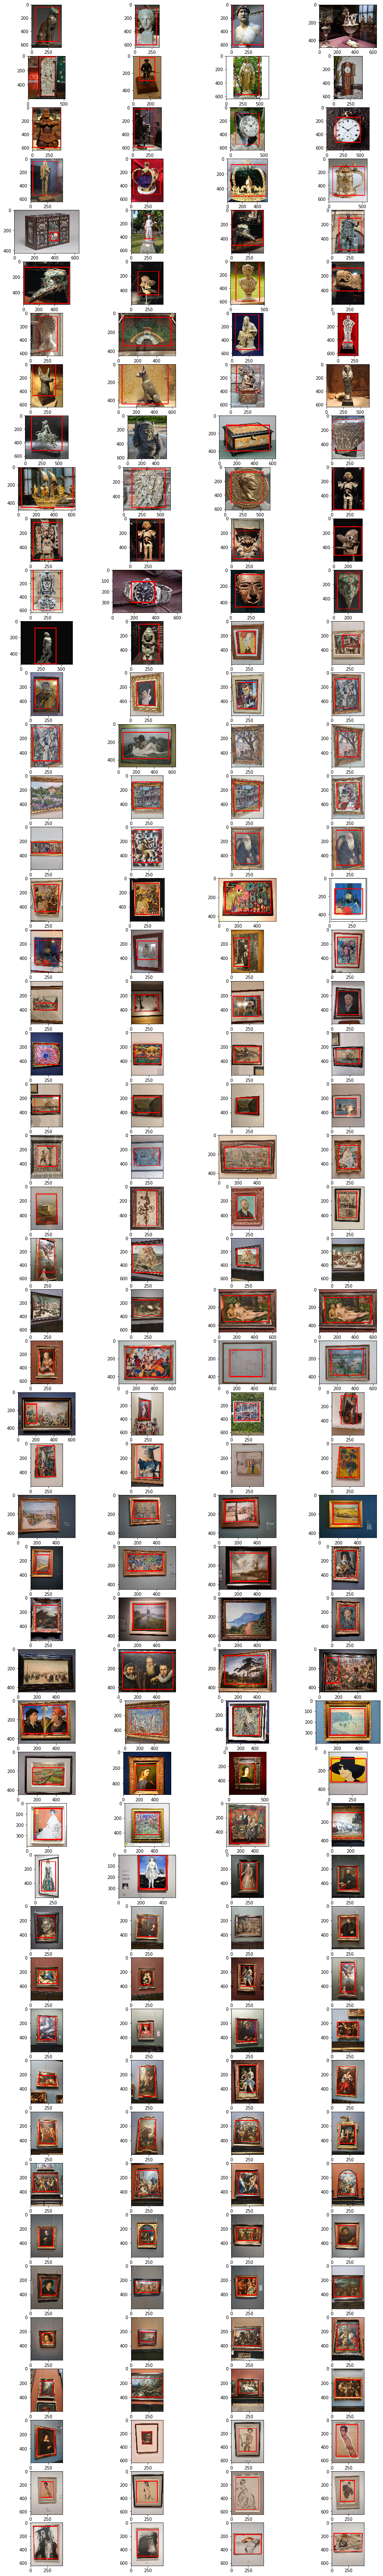

In [52]:
import matplotlib.pyplot as plt

model.load_state_dict(best_model_wts)
model.eval()

fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 64
for counter, i in enumerate(val[:200]):
    
    output = model(data[i][0].unsqueeze(0))
    
    bbox = output[0]['boxes'].detach().numpy()
    
    #print(bbox.shape)
    img = Image.open(data[i][1]['image_path'])
    img.thumbnail((640, 640))
    
    if bbox.shape[0]>0:
        #bbox *= [img.width, img.height, img.width, img.height/400]
        bbox = (bbox[0]).tolist()
    print(bbox)
    
    imgd = ImageDraw.Draw(img)
    
    if bbox:
        imgd.rectangle(bbox, outline='red', width=10)

    #img.show()
    try:
        fig.add_subplot(rows, columns, counter+1)
        plt.imshow(img, aspect='equal')
    except:
        pass
plt.show()

### Test with single new image

In [45]:
model.eval()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
#scaler = transforms.Resize((500, 300))
img = Image.open('/Images/1006.jpeg')
img.thumbnail((640,640))
output = model(normalize(to_tensor(img)).unsqueeze(0))
print(output)
bbox = output[0]['boxes'].detach().numpy()
imgd = ImageDraw.Draw(img)
imgd.rectangle(bbox[0].tolist(), outline='red', width=10)
img.show()

[{'boxes': tensor([[243.7901,  22.8614, 494.4943, 368.9315],
        [202.4182,  43.0006, 393.5876, 306.8067],
        [184.0629,  54.6172, 296.2375, 304.7289]], grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.1949, 0.1406, 0.0708], grad_fn=<IndexBackward>)}]


## 3. Find images with big loss

In [52]:
lossy_samples = []
lossy_samples_i = []
empty_samples = []
model.eval()

for i in range(len(data)):
    boxes = model(data[i][0].unsqueeze(0))[0]['boxes']
    if len(boxes)>0:
        box = boxes[0]
        if i<5: print(F.l1_loss(box, data[i][1]['boxes'], reduction='sum'))
        l = torch.div(F.l1_loss(box, data[i][1]['boxes'], reduction='sum'),(data.df.w[i]*data.df.h[i]))
        lossy_samples.append(l)
        lossy_samples_i.append(i)
    else:
        empty_samples.append(i)
        
    

tensor(38.3506, grad_fn=<L1LossBackward>)
tensor(26.9736, grad_fn=<L1LossBackward>)


In [53]:
lossy_samples_n = torch.stack(lossy_samples).detach().numpy()

In [54]:
biggest_losses = lossy_samples_n.argsort()[-10:]

In [55]:
print(f'Fraction of samples without bounding box: {len(empty_samples)/len(data)}')

0.05405405405405406

In [56]:
len(empty_samples)

38

In [17]:
#biggest_losses


#print(bbox.shape)
for i in biggest_losses:
    img = Image.open(data[i][1]['image_path'])
    img.thumbnail((640, 640))

    output = model(data[i][0].unsqueeze(0))

    bbox = output[0]['boxes'].detach().numpy()


    if bbox.shape[0]>0:
        #bbox *= [img.width, img.height, img.width, img.height/400]
        bbox = (bbox[0]).tolist()
    else:
        continue
    print(bbox)


    #img = img.resize((224,224))
    imgd = ImageDraw.Draw(img)

    imgd.rectangle(bbox, outline='red', width=5)
    img.show()
    print(data[i][1]['image_path'])

[8.243609428405762, 14.118119239807129, 153.892333984375, 72.02022552490234]
./Images/crop20.jpg
[99.75885009765625, 84.81229400634766, 465.39385986328125, 371.38677978515625]
./Images/20210824_121535.jpg
[54.34978485107422, 57.71140670776367, 343.9259338378906, 448.37841796875]
./Images/20210824_121252.jpg
[149.058349609375, 68.12467193603516, 460.0979309082031, 336.99505615234375]
./Images/Albertina-monet-6.jpg
[31.54073143005371, 87.3702163696289, 153.44285583496094, 140.32533264160156]
./Images/crop19.jpg
[75.36249542236328, 67.52281188964844, 483.03680419921875, 352.46954345703125]
./Images/20210824_132909.jpg
[138.30506896972656, 64.2594223022461, 531.8388671875, 354.82293701171875]
./Images/IMG-20210921-WA0019.jpg
[93.75521850585938, 147.4561309814453, 346.8591613769531, 468.951416015625]
./Images/20210917_164659.jpg


In [69]:
model(data[empty_samples[2]][0].unsqueeze(0))

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward>)}]

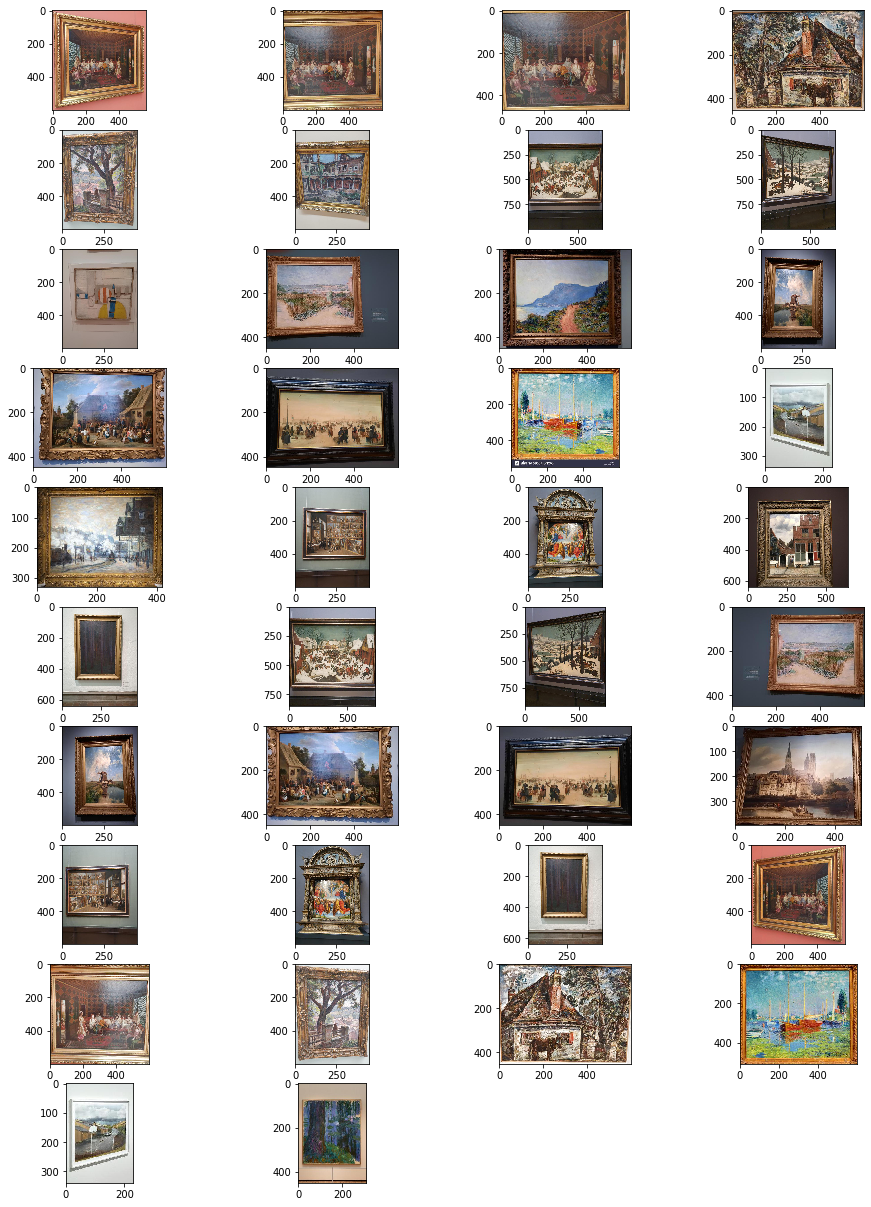

In [57]:
import shutil
#for i in empty_samples[:5]:
    #path = data[i][1]['image_path']
    #img = Image.open(data[i][1]['image_path'])
    #img.show()
    #file_path = path.split('/')[-1]
    #shutil.copy(path, 'missed_images/'+file_path)
    
fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 64
for counter, i in enumerate(empty_samples):
    img = Image.open(data[i][1]['image_path'])

    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img, aspect='equal')
plt.show()

In [ ]:
Image.open('./Images/20210821_144858.jpg').show()

## Reduce size of model by deleting parts (failed, not used)

In [5]:
import pickle
model_dict = pickle.load(open('mobilenet_320_all_2209_2.pkl', 'rb'))

In [10]:
model = get_model_simple()
model.load_state_dict(model_dict)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [11]:
model(data[0][0].unsqueeze(0))

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[ 92.2677, 126.1916, 468.7076, 442.5669]], grad_fn=<StackBackward>),
  'labels': tensor([1]),
  'scores': tensor([0.7964], grad_fn=<IndexBackward>)}]

In [36]:
torch.nn.Sequential(torch.nn.Identity())

Sequential(
  (0): Identity()
)

In [42]:
model.roi_heads.box_predictor.cls_score = torch.nn.Sequential(torch.nn.Identity(in_features=1024))
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [44]:
model.eval()
model(data[1][0].unsqueeze(0))

IndexError: index 99442 is out of bounds for dimension 0 with size 150

In [39]:
%time model(data[0][0].unsqueeze(0))

CPU times: user 354 ms, sys: 1.82 ms, total: 356 ms
Wall time: 199 ms


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([])}]

### Helper funciton Convert label csv to different image size

In [15]:
def convertLabelCsvSize(old_csv, new_csv, new_width, new_height):

    df = pd.read_csv(old_csv, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
    new_size = 320
    c1 = np.round(df.c1/df.w * new_width).astype('int')
    c2 = np.round(df.c2/df.h * new_height).astype('int')
    c3 = np.round(df.c3/df.w * new_width).astype('int')
    c4 = np.round(df.c4/df.h * new_height).astype('int')
    df2 = pd.DataFrame({'target':df.target, 'c1':c1, 'c2':c2, 'c3':c3, 'c4':c4, 'imageFile':df.imageFile, 'w':new_width, 'h':new_height}, columns=None)
        
    df2.to_csv(new_csv, header=False, index=False)
    


In [17]:
old_csv = labels_csv
new_csv = './labels_two_classes_320.csv'
size = 320

convertLabelCsvSize(old_csv, new_csv, size, size)


## Test if more data is needed

In [56]:
data035, _ = get_strat_sample_idc(data, 0.35, 2)
data035
data035targets = np.array(data.targets)[data035]
#data035targets

In [57]:
data070, _ = get_strat_sample_idc(data, 0.7, 2)
data070targets = np.array(data.targets)[data070]

In [54]:
strat = StratifiedKFold(2, shuffle=True)
folds = strat.split(data035targets, data035targets)
for t,v in folds:
    print(np.array(data035)[t])
    print(np.array(data035)[v])

In [27]:
def evaluate(dataset_idc, dataset_targets, model=None):
    
    ''' 
    Helper function to test different models with fixed parameters
    In a different notebook this function is also used to compare the results for different fractions of the training dataset, to estimate the impact of additional data
    '''
    
    strat = StratifiedKFold(3, shuffle=True)
    
    num_epochs = 3
    
    batch_size = 6
    
    val_loss_history = []
    best_loss = 10e10

    best_and_stable = {'lr_bb': 0.0044307957930878675, 'wd_bb': 1.1705566870530096e-06, 'momentum': 0.8161086619071785}

    lr_bb = best_and_stable['lr_bb']
    wd_bb = best_and_stable['wd_bb']
    momentum = best_and_stable['momentum']
    
    if not model:
        model = get_model_simple()

    #print('to update: ')
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
    
    model.train()
    optimizer = torch.optim.SGD(params_to_update, lr=lr_bb, weight_decay=wd_bb, momentum=momentum)
    
    
    for epoch in range(num_epochs):
        
        epoch_val_loss = 0
        epoch_train_loss = 0
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss = []
        val_loss = []
        
        folds = strat.split(dataset_targets, dataset_targets)

        for train_fold_idc, val_fold_idc in folds:
            
            train_ds_idc = np.array(dataset_idc)[train_fold_idc]
            val_ds_idc = np.array(dataset_idc)[val_fold_idc]

            train_data = RPNDataset('./Images', labels_csv, train_ds_idc)
            val_data = RPNDataset('./Images', labels_csv, val_ds_idc)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
            val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

            # Each epoch has a training and validation phase

            running_loss = 0.0

            running_corrects = 0

            # Iterate over data.
            with torch.set_grad_enabled(True):

                for img, targets in train_loader:

                    img = list(image for image in img)
                    #print(targets)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)
                    #print('loss dict: ', loss_dict)
                    #print('bb example: ', targets['boxes'])

                    loss = sum(loss for loss in loss_dict.values())
                    #loss = loss_dict['loss_box_reg'] + loss_dict['loss_objectness'] + loss_dict['loss_rpn_box_reg']
                    loss_value = loss.detach().item()
                    #print('loss: ', loss)

                    train_loss.append(loss_value) 
                    #print('train_loss: ', train_loss)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    gc.collect()


            with torch.set_grad_enabled(False):

                for img, targets in val_loader:

                    img = list(image for image in img)
                    #print(targets)
                    targets = [{k: v for k, v in t.items()} for t in targets]

                    for target in targets:
                        target['boxes'] = target['boxes'].unsqueeze(0)
                        target['labels'] = target['labels'].unsqueeze(0)
                        target['image_id'] = target['image_id'].unsqueeze(0)

                    loss_dict = model(img, targets)
                    

                    loss = sum(loss for loss in loss_dict.values())
                    loss_value = loss.detach().item()

                    val_loss.append(loss_value)
                    gc.collect()
        
        epoch_train_loss = sum(train_loss)/len(train_loss)

        print('Train avg batch Loss: {:.4f}, per Instance: {:.4f} '.format(epoch_train_loss, epoch_train_loss/batch_size))
        
        epoch_val_loss = sum(val_loss)/len(val_loss)

        print('Val avg batch Loss: {:.4f},  per Instance: {:.4f} '.format(epoch_val_loss, epoch_val_loss/batch_size))
              
        val_loss_history.append(epoch_val_loss)

        
    
    
    avg_val_loss = sum(val_loss_history)/len(val_loss_history)
    
    print('val loss history: ', val_loss_history, avg_val_loss)
        
    return val_loss_history
    
    

0.07118237018585205

In [74]:
val035 = evaluate(data035, data035targets)

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train avg batch Loss: 0.3977, per Instance: 0.0994 
Val avg batch Loss: 0.2874,  per Instance: 0.0719 
Epoch 1/2
----------
Train avg batch Loss: 0.2758, per Instance: 0.0690 
Val avg batch Loss: 0.2833,  per Instance: 0.0708 
Epoch 2/2
----------
Train avg batch Loss: 0.2672, per Instance: 0.0668 
Val avg batch Loss: 0.2502,  per Instance: 0.0625 
val loss history:  [0.28742720797023874, 0.28334386393110805, 0.2501870192428853] 0.2736526970480773


In [75]:
val070 = evaluate(data070, data070targets)

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train avg batch Loss: 0.3408, per Instance: 0.0852 
Val avg batch Loss: 0.2829,  per Instance: 0.0707 
Epoch 1/2
----------
Train avg batch Loss: 0.2581, per Instance: 0.0645 
Val avg batch Loss: 0.2485,  per Instance: 0.0621 
Epoch 2/2
----------
Train avg batch Loss: 0.2512, per Instance: 0.0628 
Val avg batch Loss: 0.2480,  per Instance: 0.0620 
val loss history:  [0.28290356576123976, 0.24845400635890144, 0.2480495175655513] 0.25980236322856415


In [40]:
val035 = [0.28742720797023874, 0.28334386393110805, 0.2501870192428853]
val070 = [0.28290356576123976, 0.24845400635890144, 0.2480495175655513]
val085 = [0.2420953566638323, 0.22900176799704886, 0.22346264268789026]
val100 = [0.2694991478759251, 0.22917943870585955, 0.2218501368739855] #0.24017624115192338 #1050 images
val150 = [0.2390, 0.2170, 0.2100] #1500 images

In [28]:
data085, _ = get_strat_sample_idc(data, 0.85, 2)
data085targets = np.array(data.targets)[data085]
val085 = evaluate(data085, data085targets)

/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vik/anaconda3/envs/ml_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------
Train avg batch Loss: 0.2804, per Instance: 0.0467 
Val avg batch Loss: 0.2421,  per Instance: 0.0403 
Epoch 1/2
----------
Train avg batch Loss: 0.2282, per Instance: 0.0380 
Val avg batch Loss: 0.2290,  per Instance: 0.0382 
Epoch 2/2
----------
Train avg batch Loss: 0.2237, per Instance: 0.0373 
Val avg batch Loss: 0.2235,  per Instance: 0.0372 
val loss history:  [0.2420953566638323, 0.22900176799704886, 0.22346264268789026] 0.2315199224495905


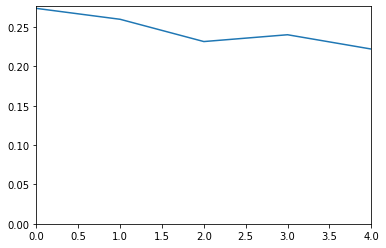

In [42]:
pd.Series([np.mean(val035), np.mean(val070), np.mean(val085), np.mean(val100), np.mean(val150)]).plot(ylim=0)

In [43]:
firsts = [val035[0], val070[0], val085[0], val100[0], val150[0]]
seconds = [val035[1], val070[1], val085[1], val100[1], val150[1]]
thirds = [val035[2], val070[2], val085[2], val100[2], val150[2]]

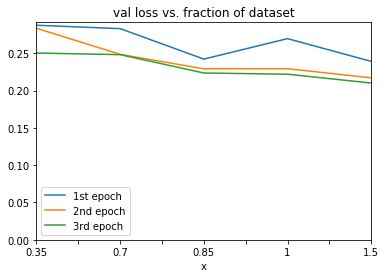

In [45]:
pd.DataFrame({'1st epoch':firsts, '2nd epoch':seconds, '3rd epoch':thirds, 'x':['0.35', '0.7', '0.85', '1', '1.5']}).plot(x='x',ylim=0, title='val loss vs. fraction of dataset')

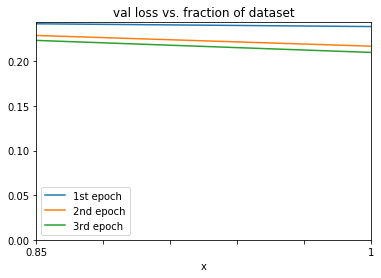

In [36]:
firsts = [val085[0], val100[0]]
seconds = [val085[1], val100[1]]
thirds = [val085[2], val100[2]]
pd.DataFrame({'1st epoch':firsts, '2nd epoch':seconds, '3rd epoch':thirds, 'x':[ '0.85', '1']}).plot(x='x', ylim=0,title='val loss vs. fraction of dataset')

In [ ]:
val_full = evaluate(data, data.targets, model_full)

	 roi_heads.box_predictor.cls_score.weight
	 roi_heads.box_predictor.cls_score.bias
	 roi_heads.box_predictor.bbox_pred.weight
	 roi_heads.box_predictor.bbox_pred.bias
Epoch 0/2
----------


In [11]:
np.arange(len(data.targets))

array([   0,    1,    2, ..., 1631, 1632, 1633])